# Random Forest
## Import CSV file

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math
from typing import List

# I'm using this guide as my reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

features = pd.read_csv('output.csv')
# print("Full list of all column names:")
# for signal in features.columns:
#     print(signal)
display(features)

,timestamps,IMUAccelerationSignal1,IMUAccelerationSignal2,IMUAccelerationSignal3,IMURotationalAccelerationSignal1,IMURotationalAccelerationSignal2,IMURotationalAccelerationSignal3,FrontLeftWheelRotSpeed,FLTireCombinedSlip,FLTireLongitudinalSlip,...,RRTireLongitudinalSlip,YawAngle,VehicleSideSlip,PitchAngle,RollAngle,VehicleMass,CoGAccelerationSignal1,SteeringWheelAng,AccelerationPedalPosition,BrakePedalPosition
0,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.763538e+01,0.025261,0.020279,...,0.018746,0.000000e+00,0.000000e+00,0.000726,0.000000e+00,2113.0,0.000000,0.00,0.9,0.0
1,0.01,-0.399903,3.381164e-07,-0.087218,2.154627e-07,8.655944e-02,8.842118e-08,3.846107e+01,0.003806,-0.003009,...,-0.002130,1.102977e-12,4.346364e-11,0.000732,2.571933e-12,2113.0,-0.375010,0.00,0.9,0.0
2,0.02,-0.192478,1.115148e-06,0.045476,7.316415e-07,2.388031e-02,2.747243e-07,3.843294e+01,0.001308,-0.000836,...,-0.001108,1.318252e-11,2.736328e-10,0.000745,3.277860e-11,2113.0,-0.185555,0.00,0.9,0.0
3,0.03,-0.258041,1.720578e-06,0.055958,1.163028e-06,3.764213e-02,3.778104e-07,3.828084e+01,0.003121,0.002424,...,0.003440,5.352696e-11,7.603806e-10,0.000762,1.401644e-10,2113.0,-0.247140,0.00,0.9,0.0
4,0.04,-0.403705,2.032940e-06,0.023671,1.390021e-06,7.592145e-02,3.829092e-07,3.831077e+01,0.001447,0.001008,...,0.001821,1.317082e-10,1.401602e-09,0.000783,3.656557e-10,2113.0,-0.381785,0.00,0.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19.96,-0.000017,-8.002418e-05,-0.000010,-9.938923e-06,2.647248e-06,-6.222613e-05,-1.924308e-12,0.000460,0.000436,...,-0.000745,2.415607e-01,0.000000e+00,0.000120,6.055171e-04,2113.0,-0.000018,1.92,0.0,0.9
1997,19.97,-0.000017,-1.093048e-04,-0.000009,-1.675144e-05,2.014346e-06,-7.932454e-05,-1.898155e-12,0.000457,0.000439,...,-0.000757,2.415608e-01,0.000000e+00,0.000120,6.056206e-04,2113.0,-0.000018,1.92,0.0,0.9
1998,19.98,-0.000017,-1.322358e-04,-0.000008,-2.253086e-05,1.353443e-06,-9.191586e-05,-1.872371e-12,0.000455,0.000443,...,-0.000770,2.415608e-01,0.000000e+00,0.000120,6.057224e-04,2113.0,-0.000017,1.92,0.0,0.9
1999,19.99,-0.000016,-1.477595e-04,-0.000006,-2.700216e-05,6.840511e-07,-9.944198e-05,-1.846917e-12,0.000453,0.000447,...,-0.000784,2.415608e-01,0.000000e+00,0.000120,6.058218e-04,2113.0,-0.000015,1.92,0.0,0.9


In [76]:
# Plotting time-series data
import plotly.express as px

fig = px.line(features, x='timestamps', y="VehicleSideSlip")
fig.show()

## Pre-Processing of Dataset

The lateral slip in Dyna4 $s_y$ is defined as:
$s_y = \frac{v_y - (r_{dyn} \cdot \Omega)}{\mid r_{dyn} \cdot \Omega \mid \cdot v_{num}}$
For more information, see the 'Slip Calculation' help document from Dyna4.

For a free rolling tire the following relation between lateral slip  and slip angle $\alpha$ is:
$\alpha = \arctan(s_y)$
This is the equation, we have to apply to the signal called TireLateralSlip for each wheel.

In [77]:
#Changing LateralSlip as explained above
for index, row in features.iterrows():
    features.at[index,'FRTireLateralSlip'] = math.atan(row['FRTireLateralSlip'])
    features.at[index,'FLTireLateralSlip'] = math.atan(row['FLTireLateralSlip'])
    features.at[index,'RLTireLateralSlip'] = math.atan(row['RLTireLateralSlip'])
    features.at[index,'RRTireLateralSlip'] = math.atan(row['RRTireLateralSlip'])

def exclude_features(ex_features: List[str], original_dataset: pd.DataFrame) -> None:
    """Function that removes certain features fron dataset"""
    for f in ex_features:
        original_dataset = original_dataset.drop(labels = f,axis = 'columns')

# Excluding features that we shouldn't train on:
features_to_exclude = [
    'YawAngle',
    'PitchAngle',
    'RollAngle',
    'FRTireLateralSlip',
    'FLTireLateralSlip',
    'RLTireLateralSlip',
    'RRTireLateralSlip',
    'FRTireLongitudinalSlip',
    'FLTireLongitudinalSlip',
    'RRTireLongitudinalSlip',
    'RLTireLongitudinalSlip',
    'FLTireCombinedSlip',
    'FRTireCombinedSlip',
    'RLTireCombinedSlip',
    'RRTireCombinedSlip',
    'FLTireCombinedForce',
    'FRTireCombinedForce',
    'RLTireCombinedForce',
    'RRTireCombinedForce',
    'FLTireContactPointForceSignal3',
    'FRTireContactPointForceSignal3',
    'RLTireContactPointForceSignal3',
    'RRTireContactPointForceSignal3',
    'FLTireCombinedMaxForce',
    'FRTireCombinedMaxForce',
    'RLTireCombinedMaxForce',
    'RRTireCombinedMaxForce',
    'CoGAccelerationSignal1',
    'timestamps',
]
features = features.drop(columns=features_to_exclude)
# exclude_features(features_to_exclude, features)                                                          

## Define Targets and Features, and Split on Training, Validation, and Test Data
- Training Dataset: The sample of data used to fit the model.
- Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
- Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [78]:
# Separate features and targets
targets = np.array(features['VehicleSideSlip'])

# Remove the targets from the features
features = features.drop('VehicleSideSlip', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

display(features.columns)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size = 0.25, random_state = 42)

# Checking that the shapes look correct
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_targets.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_targets.shape)

Index(['IMUAccelerationSignal1', 'IMUAccelerationSignal2',
       'IMUAccelerationSignal3', 'IMURotationalAccelerationSignal1',
       'IMURotationalAccelerationSignal2', 'IMURotationalAccelerationSignal3',
       'FrontLeftWheelRotSpeed', 'WheelRadius', 'FrontRightWheelRotSpeed',
       'RearLeftWheelRotSpeed', 'RearRightWheelRotSpeed', 'VehicleMass',
       'SteeringWheelAng', 'AccelerationPedalPosition', 'BrakePedalPosition'],
      dtype='object')

Training Features Shape: (1500, 15)
Training Labels Shape: (1500,)
Testing Features Shape: (501, 15)
Testing Labels Shape: (501,)


In [79]:
def exclude_features(ex_features: List[str], original_dataset: pd.DataFrame) -> None:
    """Function that removes certain features fron dataset"""
    for feature in ex_features:
        original_dataset = original_dataset.drop(feature, axis = 1)

## Train and Test Model

In [80]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_targets)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_targets)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / test_targets)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.0 degrees.


## Post Analysis of Results

Variable: IMURotationalAccelerationSignal3 Importance: 0.34
Variable: IMUAccelerationSignal2 Importance: 0.19
Variable: IMUAccelerationSignal3 Importance: 0.17
Variable: IMUAccelerationSignal1 Importance: 0.07
Variable: IMURotationalAccelerationSignal1 Importance: 0.07
Variable: IMURotationalAccelerationSignal2 Importance: 0.07
Variable: FrontRightWheelRotSpeed Importance: 0.02
Variable: RearLeftWheelRotSpeed Importance: 0.02
Variable: RearRightWheelRotSpeed Importance: 0.02
Variable: FrontLeftWheelRotSpeed Importance: 0.01
Variable: WheelRadius          Importance: 0.0
Variable: VehicleMass          Importance: 0.0
Variable: SteeringWheelAng     Importance: 0.0
Variable: AccelerationPedalPosition Importance: 0.0
Variable: BrakePedalPosition   Importance: 0.0


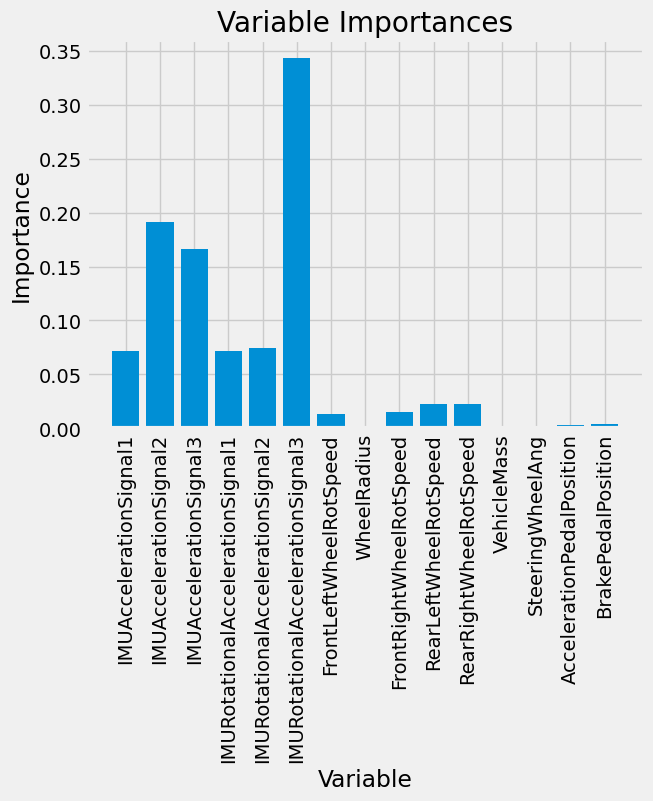

In [81]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

- Plot output compared to GT.

- Week 1:
Complete RF and LSTM example models and plot compared output and training plots.
Split dataset in training, validation, and testing.
Look at cross validation.
Predict multiple targets (at the same time?)

- Week 2:
Make bigger dataset with multiple scenarios
Stretch goal, add one more model.

- Week 3:
Test robustness with data noice.


Weekly meetings